In [1]:
import numpy as np
import scipy 
import random
import math
import csv
from scipy.stats import poisson 
from scipy.integrate import quad
import sklearn.metrics.pairwise as sk
import tensorflow as tf
import tensorflow_probability as tfp
from scipy.spatial import distance
from matplotlib import pyplot as plt
import sklearn.gaussian_process.kernels as kern
import pandas as pd
import scipy.io
from tabulate import _table_formats, tabulate
import seaborn as sns  # for nicer graphics
import warnings
import nbimporter
import Performance_metrics as metrics
import pyproj 
warnings.simplefilter(action='ignore', category=FutureWarning)
from matplotlib.ticker import FormatStrFormatter
from mpl_toolkits.mplot3d import Axes3D


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

Importing Jupyter notebook from Performance_metrics.ipynb


## Import data

In [10]:
events = np.load('../Data/taxi_data_time/xtrain_time.npy')

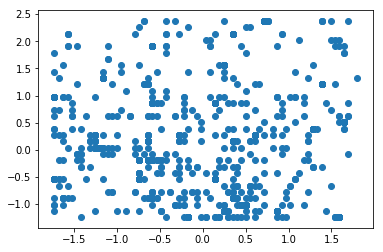

In [12]:
plt.scatter(events[:,0], events[:,1])

In [14]:
size_x_dim = max(events[:,0]) - min(events[:,0])
size_y_dim = max(events[:,1]) - min(events[:,1])
size_z_dim = max(events[:,2]) - min(events[:,2])

In [15]:
area = size_x_dim*size_y_dim*size_z_dim
print('area', area)

area 45.10961525135686


In [19]:
num_grid_points = 20
X_grid = np.empty([num_grid_points, 3])
X_grid[:, 0] = np.linspace(min(events[:,0]), max(events[:,0]), num_grid_points)
X_grid[:, 1] = np.linspace(min(events[:,1]), max(events[:,1]), num_grid_points)
X_grid[:, 2] = np.linspace(min(events[:,2]), max(events[:,2]), num_grid_points)
X_mesh, Y_mesh, Z_mesh = np.meshgrid(X_grid[:, 0],X_grid[:, 1],X_grid[:, 2])
X_vec = X_grid
x_test = np.vstack([X_mesh.flatten(),Y_mesh.flatten(), Z_mesh.flatten()]).T


In [17]:
region_bounds = np.array([[min(events[:,0]), max(events[:,0])],
                         [min(events[:,1]), max(events[:,1])],
                         [min(events[:,2]), max(events[:,2])]], dtype = np.float32)

In [18]:
tau_region_size = np.prod(region_bounds[:,1] - region_bounds[:,0])[np.newaxis]
area_cell = (X_grid[1,0] - X_grid[0,0])*(X_grid[1,1] - X_grid[0,1])*(X_grid[1,2] - X_grid[0,2])

## Import results 


In [20]:
pred_mean_MTSM = np.load('../Data/taxi_data_time/pred_mean_MTSM_6.npy')
pred_var_MTSM = np.load('../Data/taxi_data_time/pred_var_MTSM_6.npy')
latent_means = np.load('../Data/taxi_data_time/latent_means_MTSM_6.npy')
latent_vars = np.load('../Data/taxi_data_time/latent_variances_MTSM_6.npy')
alpha_final = np.load('../Data/taxi_data_time/alpha_final_MTSM_6.npy')
beta_final = np.load('../Data/taxi_data_time/beta_final_MTSM_6.npy')
samples_latent_function = np.load('../Data/taxi_data_time/samples_latent_function_MTSM_6.npy')

time_interations = np.load('../Data/taxi_data_time/time_iterations_MTSM_6.npy')
time_to_train_list = np.load('../Data/taxi_data_time/time_to_train_list_MTSM_6.npy')

## To assess convergence
nelbo = np.load('../Data/taxi_data_time/nelbo_values_MTSM_6.npy')
cross_entropy_U = np.load('../Data/taxi_data_time/crossent_vector_MTSM_6.npy')
entropy_U = np.load('../Data/taxi_data_time/ent_vector_MTSM_6.npy')
entropy_locations = np.load('../Data/taxi_data_time/ent_x_m_vector_MTSM_6.npy')
ell = np.load('../Data/taxi_data_time/ell_vector_MTSM_6.npy')
value_for_events_locations_vector = np.load('../Data/taxi_data_time/value_for_events_locations_vector_MTSM_6.npy')
value_for_thinned_events_vector = np.load('../Data/taxi_data_time/value_for_thinned_events_vector_MTSM_6.npy')

probabilities_mixture_vector = np.load('../Data/taxi_data_time/probabilities_mixture_vector_MTSM_6.npy')
means_mixture_vector = np.load('../Data/taxi_data_time/means_mixture_vector_MTSM_6.npy')
variances_mixture_vector = np.load('../Data/taxi_data_time/variances_mixture_vector_MTSM_6.npy')
value_expectation_vector = np.load('../Data/taxi_data_time/value_expectation_vector_MTSM_6.npy')
kl_lambda_max_vector = np.load('../Data/taxi_data_time/kl_lambda_max_vector_MTSM_6.npy')

## Performance

In [22]:
num_samples = 100

nlpl_mean, nlpl_std = metrics.compute_nlpl(x_test, 1, latent_means, latent_vars, 
             xtrain, 'sigmoidal', num_samples, alpha_final, beta_final, area_cell = area, code = 'Py', dim = 2)
print('nlpl', nlpl_mean)

l_test_mean, l_test_std = metrics.compute_l_test(1, x_test, x_test, 
               'sigmoidal', num_samples, area, latent_means = latent_means, latent_vars = latent_vars, 
               alpha = alpha_final, beta = beta_final,
                dim = 2, code ='Py')
print('l_test', l_test_mean)

        

nlpl 90872.31226480754
l_test -9103568.78352395


## Plots

### Counts distributions 

In [23]:
num_samples = 100
n_seeds = 100
count_matrix_our_train = np.zeros((num_samples, n_seeds))
true_number_events = xtrain.shape[0]
coverage = np.zeros((levels.shape[0],n_seeds))
for j in range(levels.shape[0]):
    for s in range(n_seeds):
        #print('seed', s)
        np.random.seed(s + j)
        for i in range(num_samples):
            #print('i', i)
            lambda_max = np.random.gamma(alpha_final, 1/(beta_final))
            latent_function = latent_means + np.sqrt(latent_vars)*np.random.normal(0, 1)
            intensity = (lambda_max*metrics.sigmoidal(latent_function))[0]
            #print('intensity', intensity.shape)
            volume = np.sum((area_cell)*intensity)
            #print('volume', volume)
            count_matrix_our_train[i,s] = np.random.poisson(volume)

        lower_5percentile = np.percentile(count_matrix_our_train[:,s], levels[j])
        upper_95percentile = np.percentile(count_matrix_our_train[:,s], 100 - levels[j])

        if true_number_events >= lower_5percentile and true_number_events <= upper_95percentile:
            coverage[j, s] = 1.
        else:
            coverage[j, s] = 0.
        sns.kdeplot(count_matrix_our_train[:,s])
        plt.axvline(xtrain.shape[0], color ='red')
    plt.show()

print(np.mean(coverage))
print(np.std(coverage))

mean_coverage = np.mean(coverage, axis = 1)
std_coverage = np.std(coverage, axis = 1)

NameError: name 'levels' is not defined

In [ ]:
num_samples = 100
n_seeds = 100
count_matrix_our_test = np.zeros((num_samples, n_seeds))
true_number_events = xtest.shape[0]
coverage_test = np.zeros((levels.shape[0],n_seeds))
for j in range(levels.shape[0]):
    for s in range(n_seeds):
        #print('seed', s)
        np.random.seed(s + j)
        for i in range(num_samples):
            #print('i', i)
            lambda_max = np.random.gamma(alpha_final, 1/(beta_final))
            latent_function = latent_means + np.sqrt(latent_vars)*np.random.normal(0, 1)
            intensity = (lambda_max*metrics.sigmoidal(latent_function) + new_scale - original_scale)[0]
            #print('intensity', intensity.shape)
            volume = np.sum((area_cell)*intensity)
            #print('volume', volume)
            count_matrix_our_test[i,s] = np.random.poisson(volume)

        lower_5percentile = np.percentile(count_matrix_our_test[:,s], levels[j])
        upper_95percentile = np.percentile(count_matrix_our_test[:,s], 100 - levels[j])

        if true_number_events >= lower_5percentile and true_number_events <= upper_95percentile:
            coverage_test[j, s] = 1.
        else:
            coverage_test[j, s] = 0.
        sns.kdeplot(count_matrix_our_test[:,s])
        plt.axvline(xtest.shape[0], color ='red')
    plt.show()

print(np.mean(coverage_test))
print(np.std(coverage_test))

mean_coverage_test = np.mean(coverage_test, axis = 1)
std_coverage_test = np.std(coverage_test, axis = 1)